## 0.0 Notebook Statement

This will be the notebook for the final model to bring together all data in a final optimsaition

The model in this notebook will work off the ernegy price, energy consumption and energy generation models with one week of data

The model will predict three days of hourly energy storage

# 1.0 Imports and Key Variables

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt


In [2]:
# input variables
time_points = 72 # h

# 2.0 Generation of practice data

In [3]:
# create sales data. Scale between 0.5 and 1
sell = np.random.random((time_points,1))/5+0.2
sell_price = pd.DataFrame(data=sell, columns=['SalePrice_£/kwh'])

In [4]:
# create purchase data. Use a two time sell price multiplier
purchase_price = sell_price.rename(columns={'SalePrice_£/kwh':'PurchasePrice_£/kwh'})
purchase_price['PurchasePrice_£/kwh'] = purchase_price['PurchasePrice_£/kwh'].apply(lambda x: x*2)

In [5]:
# create generation data. Average of 0.1 kwh per hour.
generation = np.random.random((time_points,1))/2
generation = pd.DataFrame(data=generation, columns=['Generation_kwh'])

In [6]:
# create comsumption data. Average of 0.3 kwh per hour.
consumption = np.random.random((time_points,1))/5+0.2
consumption = pd.DataFrame(data=consumption, columns=['Consumption_kwh'])

In [7]:
# combine all data
df = pd.concat([sell_price, purchase_price, generation, consumption], axis=1)

In [8]:
df.shape

(72, 4)

In [9]:
df.head(15)

,SalePrice_£/kwh,PurchasePrice_£/kwh,Generation_kwh,Consumption_kwh
0,0.216403,0.432806,0.306738,0.206176
1,0.264106,0.528212,0.261929,0.343346
2,0.299123,0.598246,0.335751,0.252910
3,0.273468,0.546935,0.044935,0.349906
4,0.312580,0.625161,0.413158,0.315279
5,0.334425,0.668851,0.019653,0.306790
6,0.218127,0.436255,0.341144,0.279326
7,0.328479,0.656958,0.280790,0.383033
8,0.309738,0.619476,0.054627,0.244899
9,0.319741,0.639482,0.357175,0.258457


# 3.0 Optimisation model

In [10]:
data = np.array(df)

In [11]:
def profit(x_input):
    '''
    Function to be minimised for the optimsation problem
    '''
    battery_size = 5 # kwh, max battery charge
    battery_charge = 1 # kwh, initial battery charge
    cost_punishment = 0 # initial cost punishment
    cost_punishment_increment = 1000 # £

    x0 = x_input[0:time_points]
    x1 = x_input[time_points:]

    battery = np.zeros(time_points+1)
    battery[0] = battery_charge

    for i in range(len(battery)-1):
        battery[i+1] = battery[i] + data[i,2] - data[i,3] + x0[i] - x1[i]
        if battery[i + 1] > battery_size:
            cost_punishment += cost_punishment_increment
        if battery[i+1] < 0:
            cost_punishment += cost_punishment_increment

    buy = x0[:] * data[:,1]
    sell = x1[:] * data[:,0]


    cost = np.sum(buy - sell) + cost_punishment
    battery_charge = battery[time_points] * np.mean(data[i,0])
    return cost - battery_charge

In [12]:
# x0 = initial purchase amount
x0 = np.array(df['Consumption_kwh'])
# x1 = initial sale amount
x1 =  np.array(df['Generation_kwh'])

In [13]:
# x0 is the energy purchased
# x1 is the energy sold
# lower bound for x0 is 0, upper bound is 3 (assumptino set from grid)
# lower bound for x1 is 0, upper bound is the PV energy generation
lb =np.concatenate((np.ones(time_points)*0, np.ones(time_points)*0),axis = 0)
ub =np.concatenate((np.ones(time_points)*3, data[:,2]), axis = 0)
bounds = Bounds(lb=lb, ub=ub)

In [14]:
x_input = np.concatenate((x0,x1),axis=0)

res = minimize(
    profit,
    x_input,
    bounds = bounds,
    method='nelder-mead',
    options={'xatol': 1e-12, 'disp': True}
    )
res.x

/tmp/ipykernel_400974/542866697.py:3: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


array([0.221983  , 0.22013679, 0.09099759, 0.72511693, 0.26201902,
       0.3026326 , 0.33177112, 0.00906329, 0.11779518, 0.06914632,
       0.41839891, 0.48401758, 0.64932374, 0.01177584, 0.4123179 ,
       0.26722823, 0.03846281, 0.22573441, 0.65635145, 0.4480362 ,
       0.43934142, 0.08680308, 0.32603128, 0.71901276, 0.23880123,
       0.01784135, 0.01194788, 0.21693051, 0.45456289, 0.29397698,
       0.23018061, 0.53369643, 0.04033968, 0.45418139, 0.52972022,
       0.09738407, 0.38711257, 0.58612114, 0.23495393, 0.0749462 ,
       0.12399502, 0.29777926, 0.70595831, 1.36238825, 0.33504458,
       0.20908369, 0.78888088, 0.21681959, 0.35847815, 0.05547133,
       0.09104671, 0.09704083, 0.15881536, 0.19326968, 0.14924945,
       0.43033875, 0.82369502, 0.00737224, 0.34920302, 0.07898181,
       0.26953957, 0.12400564, 0.22832225, 0.04901626, 0.48243896,
       0.03856651, 0.03180028, 0.5174366 , 0.21257247, 0.050645  ,
       0.03505228, 0.06724309, 0.30673762, 0.26192886, 0.33575

In [15]:
weekly_cost = profit(res.x)
weekly_cost

5.551760115598275

In [16]:
def battery_storage(x_input):
    '''
    Function to be minimised for the optimsation problem
    '''
    x0 = x_input[0:72]
    x1 = x_input[72:]

    battery = np.zeros(73)
    # initial battery charge
    battery[0] = 1
    # battery size
    battery_size = 5
    cost_punishment = 0
    for i in range(len(battery)-1):
        battery[i+1] = battery[i] + data[i,2] - data[i,3] + x0[i] - x1[i]
        if battery[i + 1] > battery_size:
            cost_punishment += 1000

    buy = x0[:] * data[:,1]
    sell = x1[:] * data[:,0]


    cost = np.sum(buy - sell) + cost_punishment
    battery_charge = battery[72] * np.mean(data[i,0])
    return battery, (cost - battery_charge)

In [17]:
(battery, profit) = battery_storage(res.x)
battery

array([1.        , 1.015807  , 0.8925975 , 0.73068477, 1.1058961 ,
       1.05263626, 1.04847909, 1.10092419, 0.72695454, 0.59985058,
       0.41053976, 0.60737812, 0.81736432, 1.07805561, 0.69177054,
       0.73780448, 0.76844436, 0.40814205, 0.39651493, 0.69903314,
       0.76658455, 0.94223109, 0.68223142, 0.62167718, 1.05030191,
       1.05551408, 0.73989662, 0.37401198, 0.28853316, 0.5182002 ,
       0.44273984, 0.32135805, 0.5611505 , 0.36076127, 0.45349591,
       0.58774961, 0.29234385, 0.34613267, 0.53472722, 0.55082036,
       0.4028905 , 0.32577952, 0.42046353, 0.77171542, 1.7756444 ,
       1.85672699, 1.82406314, 2.21943644, 2.16722081, 2.23115177,
       1.96420309, 1.77314459, 1.65924465, 1.54837151, 1.49949093,
       1.32129339, 1.4268997 , 1.87126619, 1.64029773, 1.65463175,
       1.3545518 , 1.40426521, 1.13412475, 1.11592522, 0.89927934,
       1.14422586, 0.8154235 , 0.47549781, 0.71710665, 0.72569918,
       0.43716965, 0.24245889, 0.01846871])

## 4.0 Visualising model results

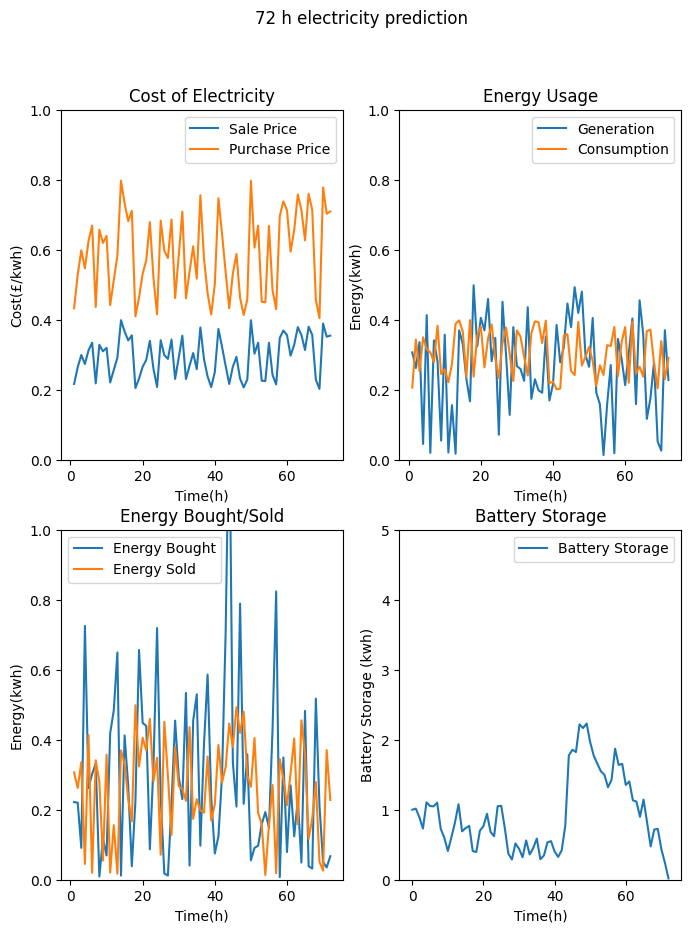

In [18]:
fig = plt.figure(figsize=(8,10))

# First subplot
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.arange(1,time_points+1,1)  , df['SalePrice_£/kwh'], label="Sale Price")
ax1.plot(np.arange(1,time_points+1,1)  , df['PurchasePrice_£/kwh'], label="Purchase Price")
ax1.set_title('Cost of Electricity')
ax1.set_ylabel('Cost(£/kwh)')
ax1.set_xlabel('Time(h)')
ax1.set_ylim([0,1])
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(2,2,2)
ax2.plot(np.arange(1,time_points+1,1), df['Generation_kwh'], label="Generation")
ax2.plot(np.arange(1,time_points+1,1), df['Consumption_kwh'], label="Consumption")
ax2.set_title('Energy Usage')
ax2.set_ylabel('Energy(kwh)')
ax2.set_xlabel('Time(h)')
ax2.set_ylim([0,1])
ax2.legend()

ax3 = fig.add_subplot(2,2,3)
ax3.plot(np.arange(1,time_points+1,1), res.x[: time_points], label="Energy Bought")
ax3.plot(np.arange(1,time_points+1,1), res.x[time_points :], label="Energy Sold")
ax3.set_title('Energy Bought/Sold')
ax3.set_ylabel('Energy(kwh)')
ax3.set_xlabel('Time(h)')
ax3.set_ylim([0,1])
ax3.legend()

ax4 = fig.add_subplot(2,2,4)
ax4.plot(np.arange(0,time_points+1,1), battery[:], label="Battery Storage")
ax4.set_title('Battery Storage')
ax4.set_ylabel('Battery Storage (kwh)')
ax4.set_xlabel('Time(h)')
ax4.set_ylim([0,5])
ax4.legend()

# Global figure methods
fig.suptitle('72 h electricity prediction')
plt.show()

## 5.0 Importing real Data

In [90]:
# data import
path = '/home/adam/code/hramzan01/market/raw_data/ACORN_A_processed.csv'
cons_data = pd.read_csv(path)

In [91]:
cons_data = cons_data[30101:30245].iloc[0::2,:]

In [92]:
Consumption_kwh = cons_data['Average energy(kWh/hh)'].reset_index().drop(columns=['index'])
Consumption_kwh = Consumption_kwh.rename(columns={'Average energy(kWh/hh)':'Consumption_kwh'})
Consumption_kwh

,Consumption_kwh
0,0.323544
1,0.279184
2,0.341687
3,0.321878
4,0.378939
...,...
67,0.328565
68,0.332408
69,0.341272
70,0.285612


In [93]:
# data import
path = '/home/adam/code/hramzan01/market/raw_data/sample_generation.csv'
gen_data = pd.read_csv(path)

In [94]:
gen_data = gen_data[['generation_w']]/1000/5
gen_data = gen_data.rename(columns={'generation_w':'Generation_kwh'})
gen_data = gen_data[:72]
gen_data

,Generation_kwh
0,0.2634
1,0.2842
2,0.1344
3,0.0370
4,0.0374
...,...
67,0.0890
68,0.2338
69,0.0778
70,0.0228


In [95]:
# data import
path = '/home/adam/code/hramzan01/market/raw_data/energy_price.csv'
price_data = pd.read_csv(path)

In [96]:
price_data = price_data[25:169].iloc[0::2,:]
price_data = price_data[['4.29']].rename(columns = {'4.29':'SalePrice_£/kwh'})
price_data = price_data.reset_index().drop(columns=['index'])
price_data

,SalePrice_£/kwh
0,4.62
1,4.56
2,4.41
3,10.56
4,10.96
...,...
67,4.91
68,5.29
69,5.48
70,5.74


In [97]:
# create purchase data. Use a two time sell price multiplier
purchase_price = price_data.rename(columns={'SalePrice_£/kwh':'PurchasePrice_£/kwh'})
purchase_price['PurchasePrice_£/kwh'] = purchase_price['PurchasePrice_£/kwh'].apply(lambda x: x*2)

In [98]:
# combine all data
df = pd.concat([price_data, purchase_price, gen_data, Consumption_kwh], axis=1)

In [99]:
df.shape

(72, 4)

In [100]:
df.head()

,SalePrice_£/kwh,PurchasePrice_£/kwh,Generation_kwh,Consumption_kwh
0,4.62,9.24,0.2634,0.323544
1,4.56,9.12,0.2842,0.279184
2,4.41,8.82,0.1344,0.341687
3,10.56,21.12,0.0370,0.321878
4,10.96,21.92,0.0374,0.378939


## 6.0 Running the optimiser on real data

In [30]:
data = np.array(df)

In [31]:
def profit(x_input):
    '''
    Function to be minimised for the optimsation problem
    '''
    battery_size = 5 # kwh, max battery charge
    battery_charge = 1 # kwh, initial battery charge
    cost_punishment = 0 # initial cost punishment
    cost_punishment_increment = 1000 # £

    x0 = x_input[0:time_points]
    x1 = x_input[time_points:]

    battery = np.zeros(time_points+1)
    battery[0] = battery_charge

    for i in range(len(battery)-1):
        battery[i+1] = battery[i] + data[i,2] - data[i,3] + x0[i] - x1[i]
        if battery[i + 1] > battery_size:
            cost_punishment += cost_punishment_increment
        if battery[i+1] < 0:
            cost_punishment += cost_punishment_increment

    buy = x0[:] * data[:,1]
    sell = x1[:] * data[:,0]


    cost = np.sum(buy - sell) + cost_punishment
    battery_charge = battery[time_points] * np.mean(data[i,0])
    return cost - battery_charge

In [32]:
# set up optimisation
x0 = np.array(df['Consumption_kwh']) # initial purchase amount
x1 =  np.array(df['Generation_kwh']) # initial sale amount
x_input = np.concatenate((x0,x1),axis=0)

In [33]:
# bounds
lb =np.concatenate((np.ones(time_points)*0, np.ones(time_points)*0),axis = 0)
ub =np.concatenate((np.ones(time_points)*3, data[:,2]), axis = 0)
bounds = Bounds(lb=lb, ub=ub)

In [34]:
res = minimize(
    profit,
    x_input,
    method='nelder-mead',
    options={'xatol': 1e-8, 'disp': True}
    )

/tmp/ipykernel_400974/228656704.py:1: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


In [35]:
# Check battery size
(battery, profit) = battery_storage(res.x)
battery

array([1.        , 1.48114484, 2.05695357, 2.29289271, 2.39992626,
       1.83522685, 0.69657957, 0.06822862, 0.34124866, 0.33590107,
       1.67252942, 1.86047466, 1.80441777, 1.97430903, 2.05271479,
       2.06194925, 2.09443344, 2.94963536, 3.07042155, 3.32809901,
       3.50553602, 4.21545471, 4.1326485 , 3.75516898, 3.96039609,
       3.70657775, 4.31918619, 4.99447257, 4.36652415, 4.34020385,
       0.00514765, 0.6666657 , 0.50168596, 1.36008053, 0.2555784 ,
       0.00999239, 0.26637678, 0.5241334 , 0.8957072 , 0.75175509,
       1.27409544, 3.15449777, 2.39585489, 3.73854772, 3.88983543,
       3.54026575, 4.22250138, 3.89797983, 3.79873547, 3.69143275,
       3.88046866, 3.49337343, 2.80397843, 2.48129941, 2.11764761,
       2.02525413, 1.43054353, 1.68123663, 1.67186371, 2.37493888,
       2.440621  , 2.45421623, 2.8263757 , 2.94952996, 3.34161878,
       2.66268497, 3.24820395, 3.24087674, 3.46116898, 2.93916371,
       2.66635802, 2.84919206, 2.58875174])

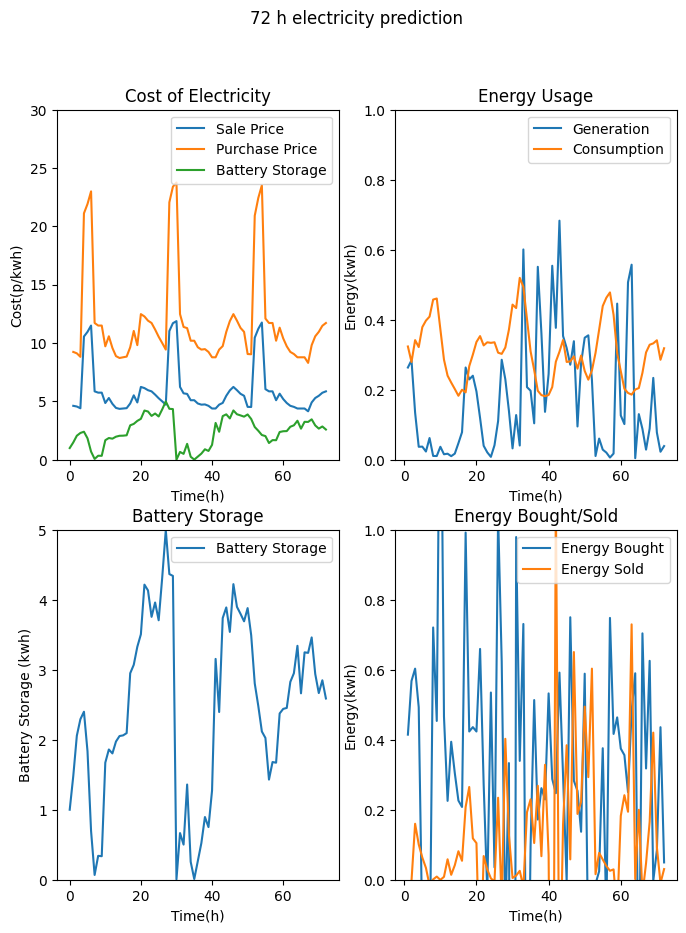

In [104]:
# Plots
fig = plt.figure(figsize=(8,10))

# First subplot
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.arange(1,73,1)  , df['SalePrice_£/kwh'], label="Sale Price")
ax1.plot(np.arange(1,73,1)  , df['PurchasePrice_£/kwh'], label="Purchase Price")
ax1.plot(np.arange(0,73,1), battery[:], label="Battery Storage")
ax1.set_title('Cost of Electricity')
ax1.set_ylabel('Cost(p/kwh)')
ax1.set_xlabel('Time(h)')
ax1.set_ylim([0,30])
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(2,2,2)
ax2.plot(np.arange(1,73,1), df['Generation_kwh'], label="Generation")
ax2.plot(np.arange(1,73,1), df['Consumption_kwh'], label="Consumption")
ax2.set_title('Energy Usage')
ax2.set_ylabel('Energy(kwh)')
ax2.set_xlabel('Time(h)')
ax2.set_ylim([0,1])
ax2.legend()

ax3 = fig.add_subplot(2,2,4)
ax3.plot(np.arange(1,73,1), res.x[: 72], label="Energy Bought")
ax3.plot(np.arange(1,73,1), res.x[72 :], label="Energy Sold")
ax3.set_title('Energy Bought/Sold')
ax3.set_ylabel('Energy(kwh)')
ax3.set_xlabel('Time(h)')
ax3.set_ylim([0,1])
ax3.legend()

ax4 = fig.add_subplot(2,2,3)
ax4.plot(np.arange(0,73,1), battery[:], label="Battery Storage")
ax4.set_title('Battery Storage')
ax4.set_ylabel('Battery Storage (kwh)')
ax4.set_xlabel('Time(h)')
ax4.set_ylim([0,5])
ax4.legend()

# Global figure methods
fig.suptitle('72 h electricity prediction')
plt.show()

In [39]:
# data import
path = '/home/adam/code/hramzan01/market/raw_data/2min_generation.csv'
gen_data = pd.read_csv(path)

In [42]:
gen_data

,Unnamed: 0,generation_w,timestamp,ss_id
0,5061268,331.0,2016-11-28 15:00:00+00:00,3020
1,7838211,213.0,2016-10-20 15:00:00+00:00,2777
2,8028861,268.0,2016-10-22 11:00:00+00:00,3442
3,8991864,103.0,2016-10-30 16:00:00+00:00,10651
4,8991865,32.0,2016-10-30 16:00:00+00:00,13670
...,...,...,...,...
132633,542717023,504.0,2021-05-27 09:00:00+00:00,27029
132634,546349198,642.0,2021-10-08 18:00:00+00:00,7759
132635,548156823,57.0,2021-10-16 16:00:00+00:00,4476
132636,552129699,1858.0,2021-09-07 15:00:00+00:00,13769


In [53]:
gen_data = gen_data.groupby(by="timestamp").mean().iloc[3006:3100]
gen_data = gen_data. drop(columns = ['Unnamed: 0', 'ss_id'])
gen_data

,generation_w
timestamp,
2020-08-11 12:00:00+00:00,1508.948052
2020-08-11 13:00:00+00:00,1504.718310
2020-08-11 14:00:00+00:00,1351.180556
2020-08-11 15:00:00+00:00,1111.272727
2020-08-11 16:00:00+00:00,759.885246
...,...
2020-08-16 09:00:00+00:00,401.722222
2020-08-16 10:00:00+00:00,578.402778
2020-08-16 11:00:00+00:00,778.300000


In [57]:
gen_data.head(50)

,generation_w
timestamp,
2020-08-11 12:00:00+00:00,1508.948052
2020-08-11 13:00:00+00:00,1504.718310
2020-08-11 14:00:00+00:00,1351.180556
2020-08-11 15:00:00+00:00,1111.272727
2020-08-11 16:00:00+00:00,759.885246
2020-08-11 17:00:00+00:00,504.183333
2020-08-11 18:00:00+00:00,209.730769
2020-08-11 19:00:00+00:00,49.438596
2020-08-11 20:00:00+00:00,403.000000


In [71]:
new_data_1 = gen_data.iloc[0:12]
new_data_1 = pd.concat([new_data_1,pd.DataFrame({"generation_w" : [0]}, index = [0])])
new_data_1

,generation_w
2020-08-11 12:00:00+00:00,1508.948052
2020-08-11 13:00:00+00:00,1504.718310
2020-08-11 14:00:00+00:00,1351.180556
2020-08-11 15:00:00+00:00,1111.272727
2020-08-11 16:00:00+00:00,759.885246
2020-08-11 17:00:00+00:00,504.183333
2020-08-11 18:00:00+00:00,209.730769
2020-08-11 19:00:00+00:00,49.438596
2020-08-11 20:00:00+00:00,403.000000
2020-08-11 21:00:00+00:00,627.000000


In [73]:
new_data_2 = gen_data.iloc[12:34]
new_data_2 = pd.concat([new_data_2,pd.DataFrame({"generation_w" : [0,0,0,0,0,0]}, index = [0,0,0,0,0,0])])
new_data_2

,generation_w
2020-08-12 01:00:00+00:00,85.000000
2020-08-12 02:00:00+00:00,81.000000
2020-08-12 03:00:00+00:00,32.000000
2020-08-12 04:00:00+00:00,51.000000
2020-08-12 05:00:00+00:00,42.800000
2020-08-12 06:00:00+00:00,147.551724
2020-08-12 07:00:00+00:00,401.983333
2020-08-12 08:00:00+00:00,646.275862
2020-08-12 09:00:00+00:00,897.841270
2020-08-12 10:00:00+00:00,1403.104478


In [84]:
new_data_3 = gen_data.iloc[34:50]
new_data_3 = pd.concat([new_data_2,pd.DataFrame({"generation_w" : [0,0,0]}, index = [0,0,0])])
new_data_3

,generation_w
2020-08-12 01:00:00+00:00,85.000000
2020-08-12 02:00:00+00:00,81.000000
2020-08-12 03:00:00+00:00,32.000000
2020-08-12 04:00:00+00:00,51.000000
2020-08-12 05:00:00+00:00,42.800000
2020-08-12 06:00:00+00:00,147.551724
2020-08-12 07:00:00+00:00,401.983333
2020-08-12 08:00:00+00:00,646.275862
2020-08-12 09:00:00+00:00,897.841270
2020-08-12 10:00:00+00:00,1403.104478


In [124]:
gen_data = pd.concat([new_data_1, new_data_2, new_data_3])
gen_data

,generation_w
2020-08-11 12:00:00+00:00,1508.948052
2020-08-11 13:00:00+00:00,1504.718310
2020-08-11 14:00:00+00:00,1351.180556
2020-08-11 15:00:00+00:00,1111.272727
2020-08-11 16:00:00+00:00,759.885246
...,...
0,0.000000
0,0.000000
0,0.000000
0,0.000000


In [125]:
gen_data = gen_data[['generation_w']]/1000/3
gen_data = gen_data.rename(columns={'generation_w':'Generation_kwh'})
gen_data = gen_data.reset_index()
gen_data = gen_data.drop(columns='index')
gen_data

,Generation_kwh
0,0.502983
1,0.501573
2,0.450394
3,0.370424
4,0.253295
...,...
67,0.000000
68,0.000000
69,0.000000
70,0.000000


In [126]:
# combine all data
df = pd.concat([price_data, purchase_price, gen_data, Consumption_kwh], axis=1)

In [127]:
df.head()

,SalePrice_£/kwh,PurchasePrice_£/kwh,Generation_kwh,Consumption_kwh
0,4.62,9.24,0.502983,0.323544
1,4.56,9.12,0.501573,0.279184
2,4.41,8.82,0.450394,0.341687
3,10.56,21.12,0.370424,0.321878
4,10.96,21.92,0.253295,0.378939


In [128]:
data = np.array(df)

In [129]:
def profit(x_input):
    '''
    Function to be minimised for the optimsation problem
    '''
    battery_size = 5 # kwh, max battery charge
    battery_charge = 1 # kwh, initial battery charge
    cost_punishment = 0 # initial cost punishment
    cost_punishment_increment = 1000 # £

    x0 = x_input[0:time_points]
    x1 = x_input[time_points:]

    battery = np.zeros(time_points+1)
    battery[0] = battery_charge

    for i in range(len(battery)-1):
        battery[i+1] = battery[i] + data[i,2] - data[i,3] + x0[i] - x1[i]
        if battery[i + 1] > battery_size:
            cost_punishment += cost_punishment_increment
        if battery[i+1] < 0:
            cost_punishment += cost_punishment_increment

    buy = x0[:] * data[:,1]
    sell = x1[:] * data[:,0]


    cost = np.sum(buy - sell) + cost_punishment
    battery_charge = battery[time_points] * np.mean(data[i,0])
    return cost - battery_charge

In [130]:
# set up optimisation
x0 = np.array(df['Consumption_kwh']) # initial purchase amount
x1 =  np.array(df['Generation_kwh']) # initial sale amount
x_input = np.concatenate((x0,x1),axis=0)

In [131]:
# bounds
lb =np.concatenate((np.ones(time_points)*0, np.ones(time_points)*0),axis = 0)
ub =np.concatenate((np.ones(time_points)*3, data[:,2]), axis = 0)
bounds = Bounds(lb=lb, ub=ub)

In [132]:
res = minimize(
    profit,
    x_input,
    method='nelder-mead',
    options={'xatol': 1e-8, 'disp': True}
    )

/tmp/ipykernel_400974/228656704.py:1: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(


In [133]:
# Check battery size
(battery, profit) = battery_storage(res.x)
battery

array([1.00000000e+00, 1.44084207e+00, 2.11927830e+00, 2.39226599e+00,
       3.65537917e+00, 2.78363532e+00, 2.03624736e+00, 1.66942228e+00,
       1.98978690e+00, 2.11454595e+00, 3.02360530e+00, 2.86347276e+00,
       2.90786718e+00, 2.81833903e+00, 2.14775138e+00, 2.57766812e+00,
       3.28858352e+00, 3.58008075e+00, 3.59232349e+00, 3.21539761e+00,
       2.35818032e+00, 2.10385811e+00, 1.86424230e+00, 1.91227591e+00,
       1.87125212e+00, 2.42812368e+00, 3.28442077e+00, 4.97677415e+00,
       4.30602718e+00, 2.92589827e+00, 2.33269260e-04, 7.73914044e-01,
       5.91362897e-02, 4.29603345e-03, 4.93977893e-01, 1.22274814e+00,
       1.08302063e+00, 1.19696602e+00, 1.20479949e+00, 1.17336065e+00,
       1.24321432e+00, 1.31509421e+00, 1.52961090e+00, 1.41922154e+00,
       2.30106737e+00, 2.38214520e+00, 1.77267649e+00, 2.23591480e+00,
       2.22724636e+00, 2.57638465e+00, 4.15982770e+00, 4.99962029e+00,
       3.78040571e+00, 1.56250134e+00, 4.01580318e-02, 1.56886877e+00,
      

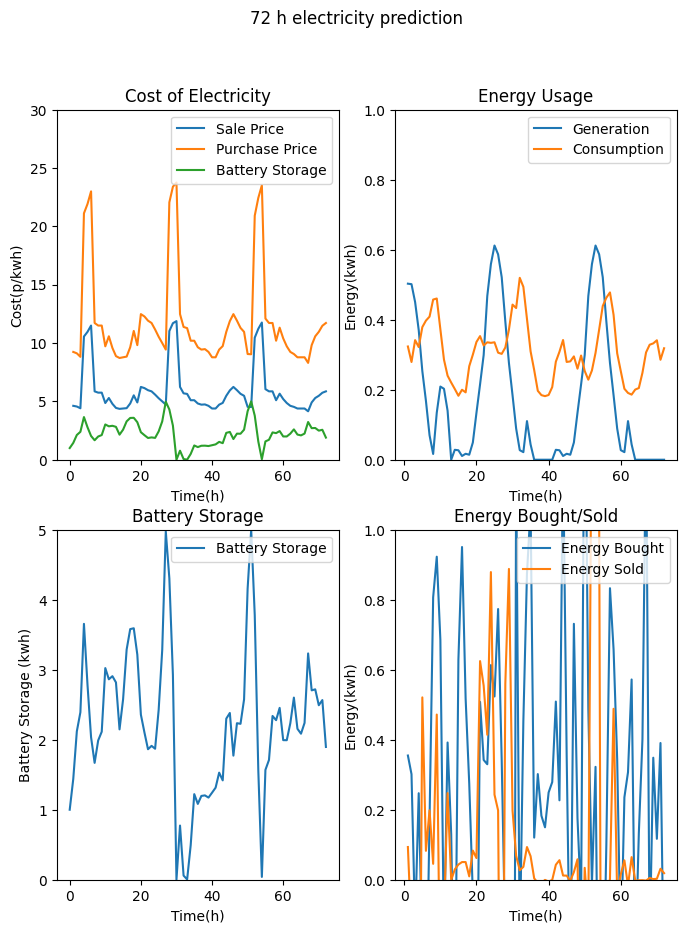

In [134]:
# Plots
fig = plt.figure(figsize=(8,10))

# First subplot
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.arange(1,73,1)  , df['SalePrice_£/kwh'], label="Sale Price")
ax1.plot(np.arange(1,73,1)  , df['PurchasePrice_£/kwh'], label="Purchase Price")
ax1.plot(np.arange(0,73,1), battery[:], label="Battery Storage")
ax1.set_title('Cost of Electricity')
ax1.set_ylabel('Cost(p/kwh)')
ax1.set_xlabel('Time(h)')
ax1.set_ylim([0,30])
ax1.legend()

# Second subplot
ax2 = fig.add_subplot(2,2,2)
ax2.plot(np.arange(1,73,1), df['Generation_kwh'], label="Generation")
ax2.plot(np.arange(1,73,1), df['Consumption_kwh'], label="Consumption")
ax2.set_title('Energy Usage')
ax2.set_ylabel('Energy(kwh)')
ax2.set_xlabel('Time(h)')
ax2.set_ylim([0,1])
ax2.legend()

ax3 = fig.add_subplot(2,2,4)
ax3.plot(np.arange(1,73,1), res.x[: 72], label="Energy Bought")
ax3.plot(np.arange(1,73,1), res.x[72 :], label="Energy Sold")
ax3.set_title('Energy Bought/Sold')
ax3.set_ylabel('Energy(kwh)')
ax3.set_xlabel('Time(h)')
ax3.set_ylim([0,1])
ax3.legend()

ax4 = fig.add_subplot(2,2,3)
ax4.plot(np.arange(0,73,1), battery[:], label="Battery Storage")
ax4.set_title('Battery Storage')
ax4.set_ylabel('Battery Storage (kwh)')
ax4.set_xlabel('Time(h)')
ax4.set_ylim([0,5])
ax4.legend()

# Global figure methods
fig.suptitle('72 h electricity prediction')
plt.show()